# Image Classifier for Satellite Images Using Non Deep Learning and Deep Learning Methods

__Author__: Ruoyang ZHANG


This notebook demonstrates how we construct an image classifier using non deep learning methods.

More specifically, it will cover the following topics in order:

## Agenda 
####    1. Data Preparation: converting image data into vector form
####    2. Vanilla Random Forest as a benchmark
####    3. Data Augmentation to deal with class inbalance
####    4. Random Forest with augmented data
            4.1 Strategy 1
            4.2 Strategy 2
            4.3 Strategy 3
            4.4 Discussion
####    5. Performance comparison with CNN using pretrained InceptionV3
####    6. Conclusions
####    7. Appendix - all functions and classes contained in seperate .py files
            7.1 image_augmentation.py (Random Forest)
            7.2 custom_dset_new_alt.py (Random Forest & CNN)
            7.3 pretrained_inceptionv3_alt.py (CNN)
            7.4 train_alt.py (CNN)
            7.5 test_alt.py (CNN)
            7.6 execute_training_alt.py (CNN)

--------------------------------------------------

## 1. Data Preparation: converting image data into vector form

1. We conver the image files into single dimension vectors of 28 * 28 * 3 dimensions
2. We will also convert the image classes into integers using the following scheme:

    {'water':0, 'trees':1, 'road':2, 'barren_land': 3, 'building': 4, 'grassland':5}

In [1]:
import cv2
import os
from custom_dset_new import train_val_test_split
import numpy as np
from tqdm import tqdm

In [ ]:
# set the directory to the image data
data_dir = '/Users/ruoyangzhang/Documents/PythonWorkingDirectory/Assignment_data/images'

In [3]:
# split the dataset into train and test
# we use the function that we created for the Convolution Neural Net
# Since there is barely any hyper parameters for with the Random Forest Algorithm, we set val_proportion = 0
train_data, val_data, test_data = train_val_test_split(data_dir, train_split=0.8, val_split=0.0, test_split = 0.2)

In [4]:
# additional step to remove unwanted sys files 
ordered_train_dirs = [dir for dir in sorted(list(train_data.keys())) if os.path.split(dir)[-1] != '.DS_Store']

In [5]:
# function to convert the images to a vector
def convert_to_vector(img_dir):
    img = cv2.imread(img_dir)
    b, g, r = cv2.split(img)
    rgb_img = cv2.merge([r, g, b])
    rgb_img.shape = (1, 28*28*3)
    return(rgb_img)

In [6]:
# convert training images to input data
input_images = np.array([convert_to_vector(dir) for dir in tqdm(ordered_train_dirs)])

100%|██████████| 259200/259200 [02:10<00:00, 1982.67it/s]


In [7]:
# reshape training input data
input_images.shape = (input_images.shape[0], input_images.shape[2])

In [31]:
# construct training input labels
train_labels = np.array([train_data[dir] for dir in ordered_train_dirs])

Now we make test data into np.arrays

In [9]:
# additional step to remove unwanted sys files 
ordered_test_dirs = [testdir for testdir in sorted(list(test_data.keys())) if os.path.split(testdir)[-1] != '.DS_Store']

In [10]:
# convert testing images to input data
test_images = np.array([convert_to_vector(dir) for dir in tqdm(ordered_test_dirs)])

100%|██████████| 64800/64800 [00:36<00:00, 1792.34it/s]


In [11]:
# reshape test input data
test_images.shape = (test_images.shape[0], test_images.shape[2])

In [29]:
# construct test input labels
test_labels = np.array([test_data[testdir] for testdir in ordered_test_dirs])

## 2. Vanilla Random Forest as a benchmark

We opt to use the Random Forest algorithm for the particular mission for the following reasons:

    1. Its robust performance
    
    2. Its lack of hyper parameter tuning, this is vital since the image dataset is large (> 300k images), the training time can be significant and hyperparameter tuning should be minimised given the time constraints
    
    3. It's quick to train
    
    4. Excellent free open source implementation (Sklearn)
    
    5. Simplicity
    
We note also the disadvantage of the Random Forest algorithm:

    1. Its model size can easily get quite large and evaluation can be relatively slow
    
    2. The lack of interpretability. While decision trees are easy to interpret, a forest is not so much. Random Forest is regarded by some as a blackbox due to the weighting mechanism behind its decisions

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import metrics
from collections import Counter

In [14]:
# instantiate the classifier
clf = RandomForestClassifier(n_estimators=100, n_jobs = 5)

In [15]:
# fit the model to the data
clf.fit(input_images,train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=5,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [16]:
# make predictions
preds = clf.predict(test_images)

In [17]:
# evaluate the accuracy
print("Accuracy:",metrics.accuracy_score(test_labels, preds))

Accuracy: 0.966358024691358


In [18]:
# the confusion matrix
metrics.confusion_matrix(test_labels, preds)

array([[24137,     0,     0,     0,     0,     0],
       [   10, 11285,     0,     5,     0,    62],
       [   83,    30,  1282,    26,   134,    44],
       [    1,    44,     0, 14050,    31,   480],
       [   18,     0,    39,     2,  2943,     0],
       [   35,   650,     3,   483,     0,  8923]])

In [19]:
# its precision, recall and fscore in relation to the proportion of each class in the training data

bookmark = {0: 'precision', 1: 'recall   ', 2: 'fscore   ', 3: 'support'}
class_dict = {0: 'water', 1: 'trees', 2: 'road', 3: 'barren_land', 4: 'building', 5: 'grassland'}
train_class_count = Counter(test_data.values())
train_class_balance = {k:round(v/sum(train_class_count.values()),4) for k,v in train_class_count.items()}

print('{}, {}: {:.4f}, {}: {:.4f}, {}: {:.4f}, {}: {:.4f}, {}: {:.4f}, {}: {:.4f}'\
              .format('balance  ',
                      class_dict[0], train_class_balance[0],
                      class_dict[1], train_class_balance[1],
                      class_dict[2], train_class_balance[2],
                      class_dict[3], train_class_balance[3],
                      class_dict[4], train_class_balance[4],
                      class_dict[5], train_class_balance[5]))

print('---------------')

for i, scores in enumerate(metrics.precision_recall_fscore_support(test_labels, preds)):
    if i < 3:
        print('{}, {}: {:.4f}, {}: {:.4f}, {}: {:.4f}, {}: {:.4f}, {}: {:.4f}, {}: {:.4f}'\
              .format(bookmark[i],
                      class_dict[0], scores[0],
                      class_dict[1], scores[1],
                      class_dict[2], scores[2],
                      class_dict[3], scores[3],
                      class_dict[4], scores[4],
                      class_dict[5], scores[5]))
        print('---------------')

balance  , water: 0.3725, trees: 0.1753, road: 0.0247, barren_land: 0.2254, building: 0.0463, grassland: 0.1558
---------------
precision, water: 0.9939, trees: 0.9397, road: 0.9683, barren_land: 0.9646, building: 0.9469, grassland: 0.9384
---------------
recall   , water: 1.0000, trees: 0.9932, road: 0.8018, barren_land: 0.9619, building: 0.9803, grassland: 0.8840
---------------
fscore   , water: 0.9970, trees: 0.9657, road: 0.8772, barren_land: 0.9633, building: 0.9633, grassland: 0.9104
---------------


As we can tell, we have some evidence to suspect that the class inbalance is costing us performance. We note the following observations:

    1. the class 'road' is grossly underrepresented in the training set, potentially leading to a low recall score and low overal performance (fscore: 0.8772)
    
    2. curiously, the class 'building', despite being underrepresented in the training set, obtained an acceptable prediction performance, possibly due to its visual distinctiveness
    
    3. on the contrary, the class 'grassland', despite having a relatively fair representation (15.58%), its recall score is below overal performance (fscore: 0.9104), leading us to believe that the class is harder to distinguish from other classes, especially from 'trees' and 'barren_land'

### Going forward:

The vanilla Random Forest's performance reached a respectable 96.5% accuracy with not excellent but acceptable class-wise performance, notably with minimum engineering. 

Going forward, we keep its performance as our baseline benchmark.

We aim to improve the prediction performance of the model by artifitially balancing out the classes a bit by data augmentation of the 2 worst performing classes:

    1. road: 2
    2. grassland: 5

## 3. Data Augmentation to deal with class inbalance

We have written data augmentation functions (image_augmentation.py) which provides the following image transformations:

    1. random rotation between -25 and 25 degrees
    2. random rotation between 26 and 75 degrees
    3. random rotation either -90 or 90 degrees
    4. adding random noise to the data
    5. horizontal flip
    6. vertical flip
    7. transpose
    8. zoom (maximum 1.4x)
    
With the 8 options, we can increase the representation of a particular class by 8 fold maximum without going into composite transformations
    
We will try 3 strategies in order to evaluate which data augmentation gives us the most desired result:

    1. strategy 1
        a. to increase 2 fold the volume of the class 'road'
        b. to increase 2 fold the volume of the class 'grassland'
    2. Strategy 2
        a. to increase 4 fold the volume of the class 'road'
        b. to increase 2 fold the volume of the class 'grassland'
    3. Strategy 3
        a. to increase 3 fold the volume of the class 'road'
        b. to increase 2 fold the volume of the class 'grassland'

### Strategy 1

In [108]:
from image_augmentation import *

# set fold variables for the 2 classes
class_2_fold = 2
class_5_fold = 2

We first prep the augmented training data and the respective labels for class 2 and 5

In [109]:
# we first extract the image_dirs for class 2 & 5
class_2_dirs = [ordered_train_dirs[i] for i, cls in enumerate(train_labels) if cls == 2]
class_2_labels = np.array([2] * len(class_2_dirs) * class_2_fold)
class_5_dirs = [ordered_train_dirs[i] for i, cls in enumerate(train_labels) if cls == 5]
class_5_labels = np.array([5] * len(class_5_dirs) * class_5_fold)

In [110]:
# we then augment the data for class 2
augmented_class_2 = image_augmentation(class_2_dirs, class_2_fold)

  2%|▏         | 146/6593 [00:00<00:08, 723.97it/s]

the functions to be used for augmentation are: 
1 random_rotation_75
2 random_rotation_90


100%|██████████| 6593/6593 [00:08<00:00, 807.71it/s]


In [111]:
# we then augment the data for class 5
augmented_class_5 = image_augmentation(class_5_dirs, class_5_fold)

  0%|          | 195/40253 [00:00<00:41, 970.79it/s]

the functions to be used for augmentation are: 
1 random_rotation_75
2 horizontal_flip


100%|██████████| 40253/40253 [00:39<00:00, 1024.45it/s]


In [112]:
# new input data and labels
input_images_aug = np.concatenate((input_images,augmented_class_2,augmented_class_5), axis = 0)
train_labels_aug = np.concatenate((train_labels, class_2_labels, class_5_labels))

### Strategy 2

In [120]:
# set fold variables for the 2 classes
class_2_fold_2 = 4
class_5_fold_2 = 2

In [121]:
# we make the labels for the augmented data for class 2
class_2_labels_2 = np.array([2] * len(class_2_dirs) * class_2_fold_2)

In [123]:
# we then augment the data for class 2
augmented_class_2_2 = image_augmentation(class_2_dirs, class_2_fold_2)

  0%|          | 0/6593 [00:00<?, ?it/s]/Users/ruoyangzhang/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
  2%|▏         | 145/6593 [00:00<00:08, 721.27it/s]

the functions to be used for augmentation are: 
1 vertical_flip
2 horizontal_flip
3 random_rotation_90
4 zoom


100%|██████████| 6593/6593 [00:09<00:00, 694.62it/s]


In [126]:
# new input data and labels
input_images_aug_2 = np.concatenate((input_images,augmented_class_2_2,augmented_class_5), axis = 0)
train_labels_aug_2 = np.concatenate((train_labels, class_2_labels_2, class_5_labels))

### Strategy 3

In [144]:
# set fold variables for the 2 classes
class_2_fold_3 = 3
class_5_fold_3 = 2

In [145]:
# we make the labels for the augmented data for class 2
class_2_labels_3 = np.array([2] * len(class_2_dirs) * class_2_fold_3)

In [146]:
# we then augment the data for class 2
augmented_class_2_3 = image_augmentation(class_2_dirs, class_2_fold_3)

  1%|          | 40/6593 [00:00<00:16, 399.73it/s]

the functions to be used for augmentation are: 
1 random_rotation_90
2 random_rotation_75
3 horizontal_flip


100%|██████████| 6593/6593 [00:08<00:00, 800.33it/s]


In [149]:
# new input data and labels
input_images_aug_3 = np.concatenate((input_images,augmented_class_2_3,augmented_class_5), axis = 0)
train_labels_aug_3 = np.concatenate((train_labels, class_2_labels_3, class_5_labels))

##  4. Random Forest with augmented data

### 4.1 Strategy 1

In [113]:
# instantiate the classifier
clf_aug = RandomForestClassifier(n_estimators=100, n_jobs = 5)

In [129]:
# fit the model to the data
clf_aug.fit(input_images_aug,train_labels_aug)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=5,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [130]:
# make predictions
preds_new = clf_aug.predict(test_images)

In [131]:
# evaluate the accuracy
print("Accuracy:",metrics.accuracy_score(test_labels, preds_new))

Accuracy: 0.9700308641975308


In [132]:
# the confusion matrix
metrics.confusion_matrix(test_labels, preds_new)

array([[24137,     0,     0,     0,     0,     0],
       [   10, 11285,     0,     5,     0,    62],
       [   83,    30,  1282,    26,   134,    44],
       [    1,    44,     0, 14050,    31,   480],
       [   18,     0,    39,     2,  2943,     0],
       [   35,   650,     3,   483,     0,  8923]])

In [136]:
# its precision, recall and fscore in relation to the proportion of each class in the training data

bookmark = {0: 'precision', 1: 'recall   ', 2: 'fscore   ', 3: 'support'}
class_dict = {0: 'water', 1: 'trees', 2: 'road', 3: 'barren_land', 4: 'building', 5: 'grassland'}
train_class_count_aug = Counter(train_labels_aug)
train_class_balance_aug = {k:round(v/sum(train_class_count_aug.values()),4) for k,v in train_class_count_aug.items()}

print('{}, {}: {:.4f}, {}: {:.4f}, {}: {:.4f}, {}: {:.4f}, {}: {:.4f}, {}: {:.4f}'\
              .format('balance  ',
                      class_dict[0], train_class_balance_aug[0],
                      class_dict[1], train_class_balance_aug[1],
                      class_dict[2], train_class_balance_aug[2],
                      class_dict[3], train_class_balance_aug[3],
                      class_dict[4], train_class_balance_aug[4],
                      class_dict[5], train_class_balance_aug[5]))

print('---------------')

for i, scores in enumerate(metrics.precision_recall_fscore_support(test_labels, preds_new)):
    if i < 3:
        print('{}, {}: {:.4f}, {}: {:.4f}, {}: {:.4f}, {}: {:.4f}, {}: {:.4f}, {}: {:.4f}'\
              .format(bookmark[i],
                      class_dict[0], scores[0],
                      class_dict[1], scores[1],
                      class_dict[2], scores[2],
                      class_dict[3], scores[3],
                      class_dict[4], scores[4],
                      class_dict[5], scores[5]))
        print('---------------')

balance  , water: 0.2726, trees: 0.1288, road: 0.0560, barren_land: 0.1666, building: 0.0338, grassland: 0.3422
---------------
precision, water: 0.9946, trees: 0.9669, road: 0.9709, barren_land: 0.9823, building: 0.9463, grassland: 0.9072
---------------
recall   , water: 1.0000, trees: 0.9843, road: 0.7724, barren_land: 0.9460, building: 0.9800, grassland: 0.9453
---------------
fscore   , water: 0.9973, trees: 0.9755, road: 0.8603, barren_land: 0.9638, building: 0.9629, grassland: 0.9259
---------------


### 4.2 Strategy 2

In [137]:
# instantiate the classifier
clf_aug_2 = RandomForestClassifier(n_estimators=100, n_jobs = 5)

In [139]:
# fit the model to the data
clf_aug_2.fit(input_images_aug_2,train_labels_aug_2)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=5,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [140]:
# make predictions
preds_new_2 = clf_aug_2.predict(test_images)

In [141]:
# evaluate the accuracy
print("Accuracy:",metrics.accuracy_score(test_labels, preds_new_2))

Accuracy: 0.9695370370370371


In [142]:
# the confusion matrix
metrics.confusion_matrix(test_labels, preds_new_2)

array([[24136,     0,     1,     0,     0,     0],
       [   14, 11182,     1,     2,     0,   163],
       [   42,    28,  1455,     8,    35,    31],
       [    1,    40,    13, 13828,    23,   701],
       [    5,     1,   291,     1,  2702,     2],
       [   18,   326,     6,   221,     0,  9523]])

In [143]:
# its precision, recall and fscore in relation to the proportion of each class in the training data

bookmark = {0: 'precision', 1: 'recall   ', 2: 'fscore   ', 3: 'support'}
class_dict = {0: 'water', 1: 'trees', 2: 'road', 3: 'barren_land', 4: 'building', 5: 'grassland'}
train_class_count_aug_2 = Counter(train_labels_aug_2)
train_class_balance_aug_2 = {k:round(v/sum(train_class_count_aug_2.values()),4) for k,v in train_class_count_aug_2.items()}

print('{}, {}: {:.4f}, {}: {:.4f}, {}: {:.4f}, {}: {:.4f}, {}: {:.4f}, {}: {:.4f}'\
              .format('balance  ',
                      class_dict[0], train_class_balance_aug_2[0],
                      class_dict[1], train_class_balance_aug_2[1],
                      class_dict[2], train_class_balance_aug_2[2],
                      class_dict[3], train_class_balance_aug_2[3],
                      class_dict[4], train_class_balance_aug_2[4],
                      class_dict[5], train_class_balance_aug_2[5]))

print('---------------')

for i, scores in enumerate(metrics.precision_recall_fscore_support(test_labels, preds_new_2)):
    if i < 3:
        print('{}, {}: {:.4f}, {}: {:.4f}, {}: {:.4f}, {}: {:.4f}, {}: {:.4f}, {}: {:.4f}'\
              .format(bookmark[i],
                      class_dict[0], scores[0],
                      class_dict[1], scores[1],
                      class_dict[2], scores[2],
                      class_dict[3], scores[3],
                      class_dict[4], scores[4],
                      class_dict[5], scores[5]))
        print('---------------')

balance  , water: 0.2628, trees: 0.1241, road: 0.0900, barren_land: 0.1606, building: 0.0326, grassland: 0.3299
---------------
precision, water: 0.9967, trees: 0.9659, road: 0.8234, barren_land: 0.9835, building: 0.9790, grassland: 0.9139
---------------
recall   , water: 1.0000, trees: 0.9842, road: 0.9099, barren_land: 0.9467, building: 0.9001, grassland: 0.9434
---------------
fscore   , water: 0.9983, trees: 0.9749, road: 0.8645, barren_land: 0.9648, building: 0.9379, grassland: 0.9284
---------------


### 4.3 Strategy 3

In [150]:
# instantiate the classifier
clf_aug_3 = RandomForestClassifier(n_estimators=100, n_jobs = 5)

In [152]:
# fit the model to the data
clf_aug_3.fit(input_images_aug_3,train_labels_aug_3)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=5,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [153]:
# make predictions
preds_new_3 = clf_aug_3.predict(test_images)

In [154]:
# evaluate the accuracy
print("Accuracy:",metrics.accuracy_score(test_labels, preds_new_3))

Accuracy: 0.9702006172839506


In [155]:
# the confusion matrix
metrics.confusion_matrix(test_labels, preds_new_3)

array([[24137,     0,     0,     0,     0,     0],
       [   16, 11183,     0,     1,     0,   162],
       [   50,    30,  1395,    10,    57,    57],
       [    1,    42,    10, 13817,    23,   713],
       [   15,     0,   170,     1,  2814,     2],
       [   17,   327,     4,   223,     0,  9523]])

In [156]:
# its precision, recall and fscore in relation to the proportion of each class in the training data

bookmark = {0: 'precision', 1: 'recall   ', 2: 'fscore   ', 3: 'support'}
class_dict = {0: 'water', 1: 'trees', 2: 'road', 3: 'barren_land', 4: 'building', 5: 'grassland'}
train_class_count_aug_3 = Counter(train_labels_aug_3)
train_class_balance_aug_3 = {k:round(v/sum(train_class_count_aug_3.values()),4) for k,v in train_class_count_aug_3.items()}

print('{}, {}: {:.4f}, {}: {:.4f}, {}: {:.4f}, {}: {:.4f}, {}: {:.4f}, {}: {:.4f}'\
              .format('balance  ',
                      class_dict[0], train_class_balance_aug_3[0],
                      class_dict[1], train_class_balance_aug_3[1],
                      class_dict[2], train_class_balance_aug_3[2],
                      class_dict[3], train_class_balance_aug_3[3],
                      class_dict[4], train_class_balance_aug_3[4],
                      class_dict[5], train_class_balance_aug_3[5]))

print('---------------')

for i, scores in enumerate(metrics.precision_recall_fscore_support(test_labels, preds_new_3)):
    if i < 3:
        print('{}, {}: {:.4f}, {}: {:.4f}, {}: {:.4f}, {}: {:.4f}, {}: {:.4f}, {}: {:.4f}'\
              .format(bookmark[i],
                      class_dict[0], scores[0],
                      class_dict[1], scores[1],
                      class_dict[2], scores[2],
                      class_dict[3], scores[3],
                      class_dict[4], scores[4],
                      class_dict[5], scores[5]))
        print('---------------')

balance  , water: 0.2676, trees: 0.1264, road: 0.0734, barren_land: 0.1635, building: 0.0332, grassland: 0.3359
---------------
precision, water: 0.9959, trees: 0.9655, road: 0.8835, barren_land: 0.9833, building: 0.9724, grassland: 0.9107
---------------
recall   , water: 1.0000, trees: 0.9842, road: 0.8724, barren_land: 0.9460, building: 0.9374, grassland: 0.9434
---------------
fscore   , water: 0.9980, trees: 0.9748, road: 0.8779, barren_land: 0.9643, building: 0.9545, grassland: 0.9268
---------------


### 4.3 Discussion

In resume, we have trained 4 models with different data augmentations with the following accuracy performance:

Original Vanilla Model: 0.9664

Model of strategy 1   : 0.9700

Model of strategy 2   : 0.9695

Model of strategy 3   : 0.9702

We can see a minor increase in model accuracy after various degrees of data augmentation. From an accuracy's point of view, the data augmented models are generally superior.

However, we know that accuracy is not a very holistic metric in evaluating a model's performance. We have noted previously that :

1. the original model's performance was skewed towards classes with large sample sizes
2. the original model's precision/recall balance was weak for the aforementioned classes: 2 & 5

This is when the data augmented models performed quite differently:

1. model of strategy 1 performed poorly for class 2 and 5, with class 2's precision (0.9709) being largely superior than its recall (0.7724)
2. model of strategy 2 had a similar problem with the precision of class 2 (0.8234) being largely inferior to its recall (0.9099)
3. model of strategy 3's class-wise precision-recall balance is fairly well upheld


Overall, the original model not only lacked in accuracy, it also had class-wise performance inbalance (measured in fscore). The data augmented models performed better in that regard, but model 1 and 2 both had precision-recall balance issues for class 2, whereas model 3 achieved a relatively good level of balance, both in terms of class-wise performance and class-wise precision-recall balance.

## 5. Performance comparison with CNN using pretrained InceptionV3

### 5.1 The CNN Architecture

We applied the transfer learning technique to avoid retrainning the model from scratch.
We used the pretrained InceptionV3 model provided by the PyTorch framework for the following reasons:
    1. Its relative light weight for training in comparison with other popular architectures such as Resnet or VGG
    2. Its availability in torch.vision (there are other light architectures such as mobilenet but they are not readily available in torch.vision)
    3. Its rebust performance

We trained multiple models using this architecture:

Shared variables:

Optimisation: SGD

Loss Function: Cross Entropy

Batchsize: 32

Group 1, 8 training epochs:
    1. fully connected layers unfrozen, decaying learning rate 1e-3, step size = 7, gamma = 0.1
    2. layers after 'Conv2d_4a_3x3' unfrozen, decaying learning rate 1e-3, step size = 7, gamma = 0.1
Group 2, 5 training epochs:
    1. fully connected layers unfrozen & decaying learning rate 1e-5, step size = 3, gamma = 0.2
    2. layers after 'Conv2d_4a_3x3' unfrozen, decaying learning rate 1e-5, step size = 3, gamma = 0.2

Group 2 performed better on the validation set with considerably less training data:

Best alidation accuracy:

    Group 1:
        1. 0.8789
        2. 0.8827
    Group 2:
        1. 0.9043
        2. 0.9156   

We finally kept the 2nd model from group 2.

We chose not to further tune the hyper parameter or run any more epochs since the Random Forest algorithm provides a much superior performance in terms of accuracy.

#### Due to training being interrupted half way, the model not the testing data was not succesfully saved, please find below a proof of the best performing model (group 2 model 2)'s validation performing during training

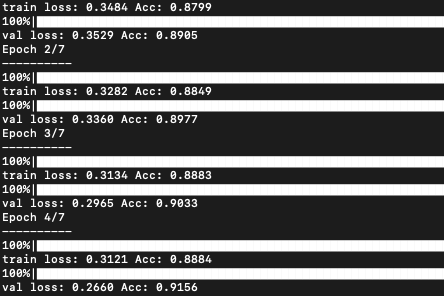

In [10]:
from IPython.display import Image
Image(filename="Screenshot.png")

## 6. Conclusions

#### In conclusion, model from strategy 3 is the most desirable model

Model description:

Algorithm: Random Forest (SkLearn implementation)

Number of estimators: 100

Data Augmentation: 
3 fold data augmentation of class 2 (road):
1. random_rotation_90
2. random_rotation_75
3. horizontal_flip


2 fold data augmentation of class 5 (grassland):
1. random_rotation_75
2. horizontal_flip

-----------------------------------------------

The model performed well with an __accuray of 0.9702__ with minimum class-wise performance inbalance.

Class-wise precision, recall and fscore:

__precision__, _water_: 0.9959, _trees_: 0.9655, _road_: 0.8835, _barren_land_: 0.9833, _building_: 0.9724, _grassland_: 0.9107

__recall__   , _water_: 1.0000, _trees_: 0.9842, _road_: 0.8724, _barren_land_: 0.9460, _building_: 0.9374, _grassland_: 0.9434

__fscore__   , _water_: 0.9980, _trees_: 0.9748, _road_: 0.8779, _barren_land_: 0.9643, _building_: 0.9545, _grassland_: 0.9268


## 7. Appendix - all functions and classes contained in seperate .py files

### 7.1 image_augmentation.py
function used in the code above to perform image data augmentation

In [11]:
import random
from scipy import ndarray
import skimage as sk
from skimage import util
from math import floor
import cv2
from tqdm import tqdm
import numpy as np


def random_rotation_25(image_array: ndarray):
    # pick a random degree of rotation between 25 on the left and 25 degrees on the right
    random_degree = random.uniform(-25, 25)
    return(sk.transform.rotate(image_array, random_degree))

def random_rotation_75(image_array: ndarray):
    # pick a random degree of rotation between 26 on the right and 75 degrees on the right
    random_degree = random.uniform(26, 75)
    return(sk.transform.rotate(image_array, random_degree))

def random_rotation_90(image_array: ndarray):
    # randomly rotate image of 90 degrees either to the left or to the right
    random_degree = random.choice([-90, 90])
    return(sk.transform.rotate(image_array, random_degree))

def random_noise(image_array: ndarray):
    # add random noise to the image
    return(sk.util.random_noise(image_array))

def horizontal_flip(image_array: ndarray):
    # horizontal flip
    return(image_array[:, ::-1])

def vertical_flip(image_array: ndarray):
    # vertical flip
    return(image_array[::-1, :])

def transpose(image_array: ndarray):
	# transpose the image
	return(image_array[::-1, ::-1])

def zoom(image_array: ndarray):
	# zoom in on the image, maximum zoom: 1.4
	dim = image_array.shape[0]
	zoom_factor = random.uniform(1.01, 1.4)
	zoomed_image = sk.transform.rescale(image_array, zoom_factor)
	crop_border = floor((zoomed_image.shape[0] - dim)/2)
	cropped_image = zoomed_image[crop_border : crop_border + dim, crop_border : crop_border + dim]
	return(cropped_image)

def image_augmentation(image_dirs, fold):
	"""
	this function will augment selected images and return it as a vector
	-----
	image_dirs: list of dirs to the images to transform
	fold: the number of times the data is augmented, max = 8
	"""

	# check if fold limits are respected
	if fold > 8 or fold < 1:
		return('fold has to be between 1 and 8')

	# convert it to an integer in case where a float was received
	fold = int(fold)

	# establish all the functions to use for augmentation
	function_list = [random_rotation_25, random_rotation_75, random_rotation_90, random_noise, horizontal_flip, vertical_flip, transpose, zoom]

	# randomly choose which augmentations to use:
	augmentations_to_use = random.sample(function_list, fold)

	# print augmentation functions to use
	print('the functions to be used for augmentation are: ')
	for i, fun in enumerate(augmentations_to_use):
		print(i+1, str(fun).split(' ')[1])

	# create a list to store results
	augmented = []

	# now we augment:
	for img_dir in tqdm(image_dirs):
		# first we read the images
		img = cv2.imread(img_dir)
		b, g, r = cv2.split(img)
		rgb_img = cv2.merge([r, g, b])

		# augment the image
		for aug in augmentations_to_use:
			aug_img = np.array(aug(rgb_img))
			aug_img.shape = (1, 3*28*28)
			augmented.append(aug_img)

	# convert to a nparray
	augmented = np.concatenate(augmented, axis = 0)

	return(augmented)

### 7.2 custom_dset_alt.py 
contains custom dataset class as well as a function to split our image dataset into train, validation and test subsets

In [ ]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import models, transforms, utils
from PIL import Image
from tqdm import tqdm
from torch.optim import Adam
import math


def train_val_test_split(data_dir, train_split, val_split, test_split):
    """
    Split data set into training, validation, and test sets.
    data_dir : path to images folder
    train_split : proportion of the data to be used for training
    val_split : proportion of the data to be used for validation
    test_split : proportion of the data to be used for testing
    """

    # getting the sub folders and getting rid off irrelevant readings
    sub_paths = [os.path.join(data_dir, file_dir) for file_dir in os.listdir(data_dir)]
    sub_paths = [path for path in sub_paths if os.path.isdir(path)]

    # creating a dict to convert string classes into integers that can be converted to tensors
    class_dict = {'water':0, 'trees':1, 'road':2, 'barren_land': 3, 'building': 4, 'grassland':5}

    # creating a dict for all files stored in the different class specific folders
    # the dict contains key-value pairs of the form: full_file_dir: class
    all_files_dict = {}
    for path in sub_paths:
        all_files_dict = {**all_files_dict, **{os.path.join(path, file_name):class_dict[os.path.split(path)[1]] for file_name in os.listdir(path)}}

    # now sample according to the proportions
    # Size of data set
    N = len(all_files_dict)
    
    # Size of train set
    train_size = math.floor(train_split * N)
    
    # Size of validation set
    val_size = math.floor(val_split * N)
    
    # List of all data indices
    indices = list(range(N))
    
    # Random selection of indices for train set
    train_ids = np.random.choice(indices, size=train_size, replace=False)
    train_ids = list(train_ids)
    
    # Deletion of indices used for train set
    indices = list(set(indices) - set(train_ids))
    
    # Random selection of indices for validation set
    val_ids = np.random.choice(indices, size=val_size, replace=False)
    val_ids = list(val_ids)
    
    # Selecting remaining indices for test set
    test_ids = list(set(indices) - set(val_ids))

    # creating subsets in the forms of dictionaries
    # these dicts contain key-value pairs of the form 'file_dir : class'
    all_files = sorted(list(all_files_dict.keys()))
    train_files = {all_files[i]: all_files_dict[all_files[i]] for i in train_ids}
    val_files = {all_files[i]: all_files_dict[all_files[i]] for i in val_ids}
    test_files = {all_files[i]: all_files_dict[all_files[i]] for i in test_ids}

    return(train_files, val_files, test_files)








class custom_dset(Dataset):
    def __init__(self, data_files, transform):
        """
        data_files : one of the outputs of the train_val_test_split function
                     a dictionary containing keys of image directories and values of their respective classes
        transform : either 'train' or 'val'
                    indicates whether the dataset is for training or validation purposees
        """

        # setting the all_file_dict to a class variable
        self.dir_to_class_dict = data_files

        # setting all file directories to a class variable
        self.all_files = sorted(list(data_files.keys()))

        # creating a list of all classes in the order of the all_files class variable
        self.labels = [data_files[key] for key in self.all_files]

        # setting the len variable
        self.len = len(self.dir_to_class_dict)
        
        # setting the image transform class method
        normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
        if transform == 'train':
            transform = transforms.Compose([
                transforms.Resize(299),
                transforms.CenterCrop(299),
                transforms.ColorJitter(hue = .05, saturation = .05),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(90, resample = Image.BILINEAR),
                transforms.ToTensor(),
                normalize,
                ])
        elif transform == 'val':
            transform = transforms.Compose([
                transforms.Resize(299),
                transforms.ToTensor(),
                normalize,
                ])
        self.transform = transform

    # the __len__ method
    def __len__(self):
        return(len(self.all_files))

    # the __getitem__ method
    def __getitem__(self, idx):
        file_name = self.all_files[idx]
        image = Image.open(file_name)
        # the images are in .png format, which comes with an extra alpha channel
        # since we're using a pretrained model,the data has to be converted to 3 channels
        image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = self.dir_to_class_dict[file_name]
        label_t = torch.from_numpy(np.array(label))
        
        return (image, label_t)

### 7.3 pretrain_inceptionv3_alt.py
class for the pretrained torch.vision inception_v3 model

In [ ]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import models, transforms, utils
from PIL import Image
from tqdm import tqdm
from torch.optim import Adam
import math


#----------------------------------------------------
# the pretrained inception v3 model class
#----------------------------------------------------

class pretrained_inception_v3(nn.Module):

	def __init__(self, num_class, use_cuda):
		super(pretrained_inception_v3, self).__init__()
		"""
		num_class : the total number of classes to predict
		use_cude : if we're using the GPU to compute and optimise
		"""

		# setting variables for if we're using the GPU, the number of output classes as well as the tensor dtype
		self.use_cuda = use_cuda
		self.num_class = num_class
		self.dtype = torch.cuda.FloatTensor if self.use_cuda else torch.FloatTensor

		# we're using the pretrained inceptionv3 model provided by torchvision
		model = models.inception_v3(pretrained=True)
		self.model = model.cuda() if self.use_cuda else model

		# freeze all layer weights
		for param in self.model.parameters():
			param.requires_grad = False

		# modifying the classifier layer
		num_features = self.model.fc.in_features
		self.model.fc = nn.Linear(num_features, num_class)

		# we choose to unfreeze the weights of parameters following(but not including) the Conv2d_4a_3x3 layer
		# act as a testing mechanism
		ct = []
		# loop through through the layers
		for name, child in self.model.named_children():
			if "Conv2d_4a_3x3" in ct:
				for params in child.parameters():
					params.requires_grad = True
			

	def forward(self, inputs):
		return(self.model(inputs))

### 7.4 train_alt.py
function for training the CNN

In [ ]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import models, transforms, utils
from PIL import Image
from tqdm import tqdm
from torch.optim import Adam, SGD, lr_scheduler
import math
from torch.utils.data import WeightedRandomSampler
from collections import Counter
import time
from pretrained_inceptionv3_alt import pretrained_inception_v3
from custom_dset_new_alt import custom_dset, train_val_test_split
import pickle


def train(data_dir, save_dir, num_class, num_epoch = 20,\
	bs = 4, lr = 1e-3, use_cuda = False, num_workers = 1,\
	name = 'model', train_prop = 0.7, val_prop = 0.2,
	step_size = 4, gamma = 0.1):
	"""
	params:
	data_dir: where the image folder is stored
	save_dir: where the model should be saved after/during training
	number_class: the number of classes to predict
	num_epoch (20 by default): the number of epochs to train
	bs (4 by default): the batch size
	lr (0.001 by default): the starting learning rate
	use_cude(false by default): boolean, wether to use the GPU
	num_workers (1 by dfault): the number of workers to use for the computation,
				note that if use_cude = True, it should be set to equal 1
	name ('model' by default): name of the model when it is saved
	train_prop (0.7 by default): the propotion of the data used for trainning
	val_prop (0.2 by default): the propotion of the data used for validation
	step_size (4 by default): the frequency for learning rate decay
	gamma (0.1 by default): the factor by which the learning rate decays
	"""

	# checkpoint beginning time
	begin = time.time()

	# instantiate the vgg model
	model = pretrained_inception_v3(num_class, use_cuda)

	# we check if the save_dir exists, if not, we create it
	if not os.path.isdir(save_dir):
		os.mkdir(save_dir)

	# define the model path
	modelpath = os.path.join(save_dir, '{}.pt'.format(name))

	# in the case of paused training, do we wish to continue training?
	if use_cuda:
		model = model.cuda()

	# setting up the loss and accuracy variables
	loss_record = {'train': np.zeros(num_epoch), 'val': np.zeros(num_epoch)}
	acc_record = {'train': np.zeros(num_epoch), 'val': np.zeros(num_epoch)}

	# setting up the loss function and optimisation method
	# we use the cross entropy for the multiclass classification task
	loss_fun = torch.nn.CrossEntropyLoss(reduction = 'sum')
	# we use stochastic gradient descend for optimisation
	optim = SGD(model.parameters(), lr = lr, momentum = 0.9)
	# we apply learning rate decay
	exp_lr_scheduler = lr_scheduler.StepLR(optim, step_size = step_size, gamma = gamma)

	# split the dataset into train, val and test
	test_prop = 1 - train_prop - val_prop
	train_data, val_data, test_data = train_val_test_split(data_dir, train_prop, val_prop, test_prop)

	# saving the test data. We save the test data first in case we want to terminate the training early
	with open('{}.pickle'.format(os.path.join(save_dir, 'test_data')), 'wb') as handle:
		pickle.dump(test_data, handle, protocol = pickle.HIGHEST_PROTOCOL)

	# set up the datasets
	dset = {'train': custom_dset(data_files = train_data, transform = 'train'),
			'val': custom_dset(data_files = val_data, transform = 'val')}

	# setting up a random weighted sampler to ensure the classes are balanced in the training phase
	# calculating weights for the dset indices according to their respective class
	train_class_sample_count = Counter(dset['train'].labels)
	sorted_train_class_sample_count = [train_class_sample_count[key] for key in sorted(train_class_sample_count.keys())]
	weights = 100000./torch.tensor(sorted_train_class_sample_count, dtype = torch.float)
	samples_weights = [weights[label] for label in dset['train'].labels]
	# the sampler
	sampler = WeightedRandomSampler(weights=samples_weights,
									num_samples=len(samples_weights),
									replacement=True)
	# the dataloaders, we create 2 dataloaders for the train and val phase seperately
	dataloaders = {'train': DataLoader(dset['train'], batch_size = bs, sampler = sampler, num_workers = num_workers, pin_memory = False),
					'val': DataLoader(dset['val'], batch_size = bs, shuffle = True, num_workers = num_workers, pin_memory = False)}

	# create variables for storing best performing weights during training
	best_model_wts = model.state_dict()
	best_acc = 0.0

	# iterate through the training epochs
	for epoch in range(num_epoch):
		print('Epoch {}/{}'.format(epoch, num_epoch - 1))
		print('-' * 10)

		# recording the running performance each epoch

		# each epoch will have a training and validation phase
		for phase in ['train', 'val']:

			# recording the dataset size
			running_loss = 0.0
			running_corrects = 0
			size = 0

			if phase == 'train':
				exp_lr_scheduler.step()
				# setting model to trainning mode
				model.train()
			else:
				# setting model to validation mode
				model.eval()

			# now we iterate over the data
			for inputs, labels in tqdm(dataloaders[phase]):
				# counting how many images is contained in this batch
				batch_count = labels.size(0)
				# if GPU is used, cudafy inputs
				if use_cuda:
					inputs = inputs.cuda()
					labels = labels.cuda()

				# zero the parameter gradients
				optim.zero_grad()

				# feed inputs into the model
				output = model(inputs)


				# calculate the loss and prediction performance statistics
				if type(output) == tuple:
					output, _ = output
				_, preds = torch.max(output.data, 1)
				loss = loss_fun(output, labels)
				running_loss += loss
				running_corrects += preds.eq(labels.view_as(preds)).sum()

				# backprop and optimise if in training stage
				if phase == 'train':
					loss.backward()
					optim.step()
				
				# update dataset size
				size += batch_count

			epoch_loss = running_loss / size
			epoch_acc = running_corrects.item() / size

			# recording the historical performance
			loss_record[phase][epoch] = epoch_loss
			acc_record[phase][epoch] = epoch_acc

			print('{} loss: {:.4F} Acc: {:.4F}'.format(phase, epoch_loss, epoch_acc))

			# deep copy and save the model if best performance
			if phase == 'val' and epoch_acc > best_acc:
				best_acc = epoch_acc
				best_model_wts = model.state_dict()
				torch.save(model.state_dict(), os.path.join(save_dir, '{}.pt'.format(name)))

	# saving the record performances
	with open('{}.pickle'.format(os.path.join(save_dir, name + '_loss_performances')), 'wb') as handle:
		pickle.dump(loss_record, handle, protocol = pickle.HIGHEST_PROTOCOL)
	with open('{}.pickle'.format(os.path.join(save_dir, name + '_acc_performances')), 'wb') as handle:
		pickle.dump(acc_record, handle, protocol = pickle.HIGHEST_PROTOCOL)

	# calculating time elapsed
	time_elapsed = time.time() - begin
	print('Training complete in {:.0F}m {:0F}s'.format(time_elapsed // 60, time_elapsed % 60))
	print('Best validation acc: {:4F}'.format(best_acc))

	# load the best model weights
	model.load_state_dict(best_model_wts)
	return(loss_record, acc_record, model, test_data)

### 7.5 test_alt.py
function for testing model performance

In [ ]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import models, transforms, utils
from PIL import Image
from tqdm import tqdm
from torch.optim import Adam, SGD, lr_scheduler
import math
from torch.utils.data import WeightedRandomSampler
from collections import Counter
import time
from pretrained_inceptionv3_alt import pretrained_inception_v3
from custom_dset_new_alt import custom_dset, train_val_test_split
import pickle


def test(model, test_files, bs):
	"""
	model : the model to be tested
	test_files : the directories to the test images, output of the train_val_test_split function
	bs : batch size

	"""

	# set model to eval mode
	model.eval()

	# cudafy model if specified
	if use_cuda:
		model = model.cuda()

	# recording the running performance and the dataset size
	running_loss = 0.0
	running_corrects = 0
	size = 0

	# set up the loss function
	loss_fun = torch.nn.CrossEntropyLoss(reduction = 'sum')

	# set up the datasets
	dset = custom_dset(data_files = test_files, transform = 'val')

	# set up the dataloader
	dataloader = DataLoader(dset, batch_size = bs, shuffle = True, num_workers = 1, pin_memory = False)

	# now iterate over the images to make predictions
	for inputs, labels in tqdm(dataloader):
		# cudafy inputs and labels if specified
		if use_cuda:
			inputs = inputs.cuda()
			labels = labels.cuda()
		# counting how many images is contained in this batch
		batch_count = labels.size(0)
		# Forward pass
		output = model(inputs)

		# calculate the loss and prediction performance statistics
		if type(output) == tuple:
			output, _ = output
			_, preds = torch.max(output.data, 1)
			loss = loss_fun(output, labels)
			running_loss += loss
			running_corrects += preds.eq(labels.view_as(preds)).sum()

	
		# update dataset size
		size += batch_count

	# compute the model's performance
	model_loss = running_loss / size
	model_acc = running_corrects / size

	return(model_loss, model_acc)

### 7.6 execute_train_alt.py
python script used for training the CNN in linux terminal with GPU

In [ ]:
from train_alt import train
from custom_dset_new_alt import train_val_test_split, custom_dset
from pretrained_inceptionv3_alt import pretrained_inception_v3


# setting up variables
data_dir = '../../data/images/'
save_dir = '../../data/CNN_model_landtype_alt/'
num_class = 6
bs = 32
name = 'model_alt'
num_epoch = 8
lr = 1e-5
step_size = 4
gamma = 0.2


# run
loss_record, acc_record, model, test_data = train(data_dir = data_dir, save_dir = save_dir, num_class = 6, 
												num_epoch = num_epoch, bs = bs, lr = lr, step_size = step_size, 
												gamma = gamma, use_cuda = True)